In [1]:
import os, sklearn, pandas, numpy as np
from sklearn import svm
import skimage, skimage.io, skimage.filters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import skimage.io

In [3]:
## NN libs
import keras
from keras import backend as K
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [4]:
# custom scripts
import config # params, constants
import data # functions that mutate outr data
from utils import utils, plot # custom functions, in local environment

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'labels' = pandas.df('img_name','breed')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


# Prepare dataset

In [5]:
# labels = pandas.read_csv('../datasets/labels.csv')
# dataset = data.Dataset(config.dataset_dir, label_name='breed')

# train_list is just a list of image names, not te actual data
# dataset = namedtuple('Dataset',['train','test','labels'])
dataset = data.init_dataset()
labels = dataset.labels
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,0b1cdb2a36dd432fcc7567959cb23798,scottish_deerhound
freq,1,126


In [6]:
# I think the smallest img has shape 160x160
shape = (160,160,3)

def crop(img):
    # I think the smallest img has shape 160x160
    return img[0:160,0:160]

def flatten(img):
    return np.array(crop(img)).flatten()

In [7]:
def extract_all_data(dataset, img_list, reshaper=crop, verbose=False):
    print('extract all data:', len(img_list))
    x_train = []
    y_train = []
    for img_name in img_list:
        img = data.read_img('train/',img_name,verbose)
        img = reshaper(img)
        x_train.append(img)
        y_train.append(data.get_label(img_name, dataset.labels))
    x_train = np.stack(x_train)
    return (x_train,y_train)

In [8]:
# Read data
amt = 20 # amount of train, test data
x_train, y_train = extract_all_data(dataset, dataset.train[0:amt])
x_test, y_test = extract_all_data(dataset, dataset.train[amt:amt + amt])
data.show_info(x_train)

extract all data: 20
extract all data: 20
__ info: __
length:  20
type:  <class 'numpy.ndarray'>
shape:  (20, 160, 160, 3)


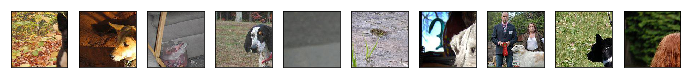

In [9]:
plot.multiple(x_train[:10])

In [10]:
def method1(x_train, x_test):
    # (optional?) ignore strucuture of image
    amt = x_train.shape[0]
    x_train = x_train.reshape(amt, -1)
    x_test = x_test.reshape(amt, -1)
    return x_train, x_test

In [11]:
def pca_compress(x_train, n_components):
    # PCA to reduce the number of dimensions
    # (compress the data (with loss))
    
    # setup the compressor
    pca = PCA(n_components=n_components)
    pca = pca.fit(x_train)
    print('before pca compression')
    data.show_info(x_train)
    print('after pca compression')
    data.show_info(x_train)
    
    # transform the data
    x_train = pca.transform(x_train)
    # additonally, return a funcion that can compress test data
    # (to make new data it compatible)
    return (x_train, pca.transform)

In [12]:
x_train, x_test = method1(x_train, x_test)

In [13]:
# build (fit) a compressor
# 'compress' is a function that compresses new data
x_train, compress = pca_compress(x_train, n_components=10)

# compress the test data
# imagine that this is done after training the classifier
x_test = compress(x_test) 

before pca compression
__ info: __
length:  20
type:  <class 'numpy.ndarray'>
shape:  (20, 76800)
after pca compression
__ info: __
length:  20
type:  <class 'numpy.ndarray'>
shape:  (20, 76800)


## Prepare the labels

Encode the labels to one-hot vectors

In [14]:
def to_numerical(dataset, labels):
    # transform ['label'] => [index]
    # (list of text => list of indices)
    return [dataset.dict_label_to_index[label] for label in labels]

In [15]:
# text-labels => int-labels
y_train = to_numerical(dataset, y_train)
y_test = to_numerical(dataset, y_test)
y_train[0:10]

[34, 27, 118, 91, 40, 35, 35, 103, 13, 29]

In [16]:
# int-labels => one-hot vectors
y_train = to_categorical(y_train)
# ? assuming y_test contains every possible class?
y_test = to_categorical(y_test)

print(y_train.shape, y_train[0].shape)
y_train[0]

(20, 119) (119,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Train a Sequential model (keras)

In [17]:
n_samples = x_train.shape[0] # = length of the list of images (matrices)
input_shape = x_train.shape[1:] # = shape of an individual image (matrix)
output_length = (y_train[0]).shape[0] # = length of an individual label
print(n_samples, input_shape)
print('output length', output_length)

20 (10,)
output length 119


In [27]:
def sequential_model(input_shape, output_length):
    model = keras.Sequential()
    model.add(Dense(128, input_shape=input_shape))
    model.add(Activation('relu')) # because relu is awesome
    # ... more layers
    
    model.add(Dense(output_length))
    model.add(Activation('softmax'))
    # in addition, return a function that displays information about the model
    return model, model.summary

In [28]:
model, summary = sequential_model(input_shape, output_length)
summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               1408      
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 119)               15351     
_________________________________________________________________
activation_12 (Activation)   (None, 119)               0         
Total params: 16,759
Trainable params: 16,759
Non-trainable params: 0
_________________________________________________________________


## Loss function
- Categorical cross-entropy loss

In [29]:
learning_rate = 0.001
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Finally train the model

In [31]:
# Compute a batch size
batch_size = round(n_samples / 10)
# n epochs = n iterations over all the training data
epochs = 5

In [42]:
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

In [41]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=1/5)

Train on 16 samples, validate on 4 samples
Epoch 1/5
16/16 [==============================] - 0s 929us/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/5
16/16 [==============================] - 0s 1ms/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/5
16/16 [==============================] - 0s 1ms/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/5
16/16 [==============================] - 0s 1ms/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/5
16/16 [==============================] - 0s 1ms/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00


In [40]:
model.predict(x_test)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)